In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TCFile import TCFile
from torchvision import models
import matplotlib.pyplot as plt
import utils

In [3]:
from models.transforms import augmentation_transform_2d, calculate_edge_mean_2d
from PIL import Image

class type_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False):
        
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'live']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathway)
            for i in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, i)
                image = Image.open(image_path)
                image = np.array(image)
                self.data.append((image, pathway_label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx][0], self.data[idx][1]
        image_tensor = torch.from_numpy(image).repeat(3, 1, 1)
        
        # Prebuilt transform
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Rotation with edge mean filling
        if self.augmentation:
            edge_mean = calculate_edge_mean_2d(image_tensor)
            image_tensor = augmentation_transform_2d(image_tensor)
            image_tensor[image_tensor==0] = edge_mean
            
        return image_tensor, label

In [26]:
from models.AugmentedDatasetWrapper import AugmentedDatasetWrapper

train_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\pathway_train_qpi"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\pathway_test_qpi"

transform = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=False)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=augmented_train_dataset, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, batch_size=64)

In [27]:
model = models.efficientnet_v2_s(pretrained=True)
for name, params in model.named_parameters():
    print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.1.block.0.0.weight
features.1.1.block.0.1.weight
features.1.1.block.0.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.2.block.0.0.weight
features.2.2.block.0.1.weight
features.2.2.block.0.1.bias
features.2.2.block.1.0.weight
features.2.2.block.1.1.weight
features.2.2.block.1.1.bias
features.2.3.block.0.0.weight
features.2.3.block.0.1.weight
features.2.3.block.0.1.bias
features.2.3.block.1.0.weight
features.2.3.block.1.1.weight
features.2.3.block.1.1.bias
features.3.0.block.0.0.weight
features.3.0.block.0.1.weight
fe

In [28]:
model = models.efficientnet_v2_s(pretrained=True)
num_features = model.classifier[1].in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

for name, params in model.named_parameters():
    if 'features.6' in name or 'features.7' in name or 'classifier' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

Total Parameters: 21,463,612
Trainable Parameters: 16,173,072


In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [30]:
import models
models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

  3%|▎         | 1/30 [00:02<01:06,  2.29s/it]

Epoch : 0
train loss : 0.057247 || train_acc : 0.2189
val loss : 0.023721 || val_acc : 0.4952


  7%|▋         | 2/30 [00:04<00:58,  2.09s/it]

Epoch : 1
train loss : 0.016571 || train_acc : 0.6252
val loss : 0.010966 || val_acc : 0.7429


 10%|█         | 3/30 [00:06<00:54,  2.03s/it]

Epoch : 2
train loss : 0.010095 || train_acc : 0.8176
val loss : 0.016331 || val_acc : 0.4857


 13%|█▎        | 4/30 [00:08<00:51,  1.99s/it]

Epoch : 3
train loss : 0.007044 || train_acc : 0.9187
val loss : 0.046448 || val_acc : 0.5143


 17%|█▋        | 5/30 [00:10<00:49,  1.97s/it]

Epoch : 4
train loss : 0.006453 || train_acc : 0.8905
val loss : 0.006351 || val_acc : 0.8571


 20%|██        | 6/30 [00:12<00:46,  1.96s/it]

Epoch : 5
train loss : 0.004407 || train_acc : 0.9386
val loss : 0.001313 || val_acc : 0.9810


 23%|██▎       | 7/30 [00:13<00:44,  1.95s/it]

Epoch : 6
train loss : 0.003088 || train_acc : 0.9751
val loss : 0.004196 || val_acc : 0.9429


 27%|██▋       | 8/30 [00:15<00:42,  1.95s/it]

Epoch : 7
train loss : 0.004391 || train_acc : 0.9784
val loss : 0.014397 || val_acc : 0.8476


 30%|███       | 9/30 [00:17<00:40,  1.94s/it]

Epoch : 8
train loss : 0.002264 || train_acc : 0.9801
val loss : 0.019439 || val_acc : 0.7429


 33%|███▎      | 10/30 [00:19<00:38,  1.95s/it]

Epoch : 9
train loss : 0.004391 || train_acc : 0.9519
val loss : 0.004156 || val_acc : 0.9048


 37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch : 10
train loss : 0.001374 || train_acc : 0.9967
val loss : 0.002800 || val_acc : 0.9524


 40%|████      | 12/30 [00:23<00:35,  1.95s/it]

Epoch : 11
train loss : 0.000552 || train_acc : 1.0000
val loss : 0.006928 || val_acc : 0.7429


 43%|████▎     | 13/30 [00:25<00:33,  1.94s/it]

Epoch : 12
train loss : 0.000374 || train_acc : 1.0000
val loss : 0.004593 || val_acc : 0.8762


 47%|████▋     | 14/30 [00:27<00:31,  1.94s/it]

Epoch : 13
train loss : 0.000207 || train_acc : 1.0000
val loss : 0.003901 || val_acc : 0.8952


 50%|█████     | 15/30 [00:29<00:29,  1.94s/it]

Epoch : 14
train loss : 0.000211 || train_acc : 1.0000
val loss : 0.003400 || val_acc : 0.9238


 53%|█████▎    | 16/30 [00:31<00:27,  1.94s/it]

Epoch : 15
train loss : 0.000173 || train_acc : 1.0000
val loss : 0.003595 || val_acc : 0.9238


 57%|█████▋    | 17/30 [00:33<00:25,  1.94s/it]

Epoch : 16
train loss : 0.000110 || train_acc : 1.0000
val loss : 0.003499 || val_acc : 0.9333


 60%|██████    | 18/30 [00:35<00:23,  1.93s/it]

Epoch : 17
train loss : 0.000085 || train_acc : 1.0000
val loss : 0.003052 || val_acc : 0.9429


 63%|██████▎   | 19/30 [00:37<00:21,  1.93s/it]

Epoch : 18
train loss : 0.000070 || train_acc : 1.0000
val loss : 0.002805 || val_acc : 0.9524


 67%|██████▋   | 20/30 [00:39<00:19,  1.94s/it]

Epoch : 19
train loss : 0.000068 || train_acc : 1.0000
val loss : 0.002559 || val_acc : 0.9714


 70%|███████   | 21/30 [00:41<00:17,  1.94s/it]

Epoch : 20
train loss : 0.000055 || train_acc : 1.0000
val loss : 0.002583 || val_acc : 0.9524


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch : 21
train loss : 0.000053 || train_acc : 1.0000
val loss : 0.002705 || val_acc : 0.9333


 77%|███████▋  | 23/30 [00:44<00:13,  1.94s/it]

Epoch : 22
train loss : 0.000046 || train_acc : 1.0000
val loss : 0.002722 || val_acc : 0.9333


 80%|████████  | 24/30 [00:46<00:11,  1.94s/it]

Epoch : 23
train loss : 0.000054 || train_acc : 1.0000
val loss : 0.002659 || val_acc : 0.9238


 80%|████████  | 24/30 [00:48<00:12,  2.01s/it]


KeyboardInterrupt: 

<h1> Finetuning </h1>

In [90]:
from models.AugmentedDatasetWrapper import AugmentedDatasetWrapper

train_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\pathway_train_mip"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\pathway_test_mip"

transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=True)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=5)

train_loader = DataLoader(dataset=augmented_train_dataset)
val_loader = DataLoader(dataset=val_dataset)

In [96]:
model = models.resnet50()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load('resnet50_mip_val_acc_0.8952.pth'))

for name, params in model.named_parameters():
    if 'layer4.2' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

Total Parameters: 23,516,228
Trainable Parameters: 4,470,788


C:\Users\김민욱\AppData\Local\Temp\ipykernel_18144\158965220.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_mip_val_acc_0.8952.p

In [97]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0009)

model = model.cuda()

In [98]:
import models
models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

  3%|▎         | 1/30 [00:12<06:13, 12.88s/it]

Epoch : 0
train loss : 0.000029 || train_acc : 1.0000
val loss : 2.321047 || val_acc : 0.6762


  7%|▋         | 2/30 [00:25<06:01, 12.91s/it]

Epoch : 1
train loss : 0.000044 || train_acc : 1.0000
val loss : 1.684381 || val_acc : 0.6857


 10%|█         | 3/30 [00:38<05:46, 12.84s/it]

Epoch : 2
train loss : 0.000012 || train_acc : 1.0000
val loss : 2.350869 || val_acc : 0.6762


 13%|█▎        | 4/30 [00:50<05:27, 12.59s/it]

Epoch : 3
train loss : 0.000005 || train_acc : 1.0000
val loss : 1.593525 || val_acc : 0.7238


 17%|█▋        | 5/30 [01:02<05:09, 12.39s/it]

Epoch : 4
train loss : 0.000031 || train_acc : 1.0000
val loss : 2.096108 || val_acc : 0.6857


 20%|██        | 6/30 [01:14<04:53, 12.22s/it]

Epoch : 5
train loss : 0.000827 || train_acc : 0.9991
val loss : 2.210617 || val_acc : 0.6762


 20%|██        | 6/30 [01:17<05:10, 12.92s/it]


KeyboardInterrupt: 

<h1> Confusion matrix </h1>

In [86]:
from models.AugmentedDatasetWrapper import AugmentedDatasetWrapper

train_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\pathway_train_mip"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\pathway_test_mip"

transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=True)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=augmented_train_dataset)
val_loader = DataLoader(dataset=val_dataset)

In [87]:
model = models.resnet50()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load('resnet50_mip_val_acc_0.8952.pth'))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_18144\2748945484.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_mip_val_acc_0.8952.

<All keys matched successfully>

In [88]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = model.cuda()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

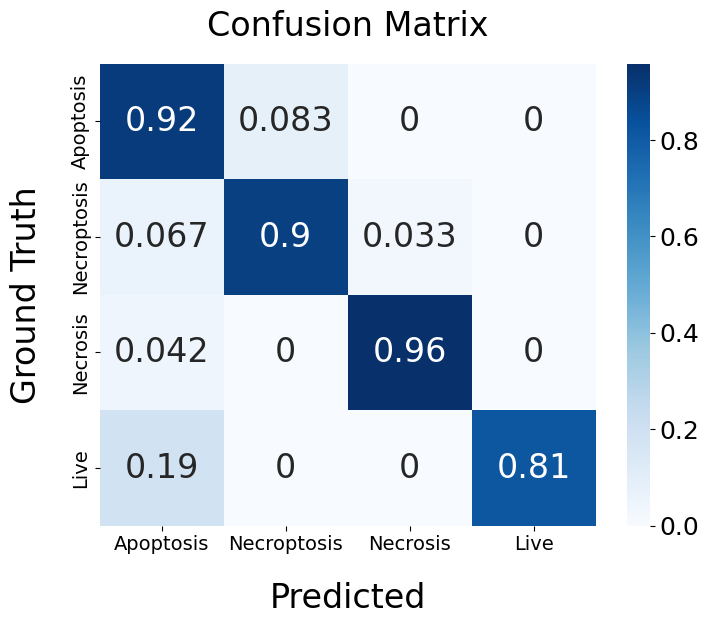

In [89]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Apoptosis", "Necroptosis", "Necrosis", "Live"], 
                                          yticklabels=["Apoptosis", "Necroptosis", "Necrosis", "Live"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()